In [ ]:
#   NOTEBOOK STRUCTURE:
# STEP 0: imports and TRAIN/TEST BEHAVIOR
# 0.1: Train step
# 0.2: Test step
# 0.3: Loop
# STEP 1: DATA
# 1.1: Paths lists, validate?
# 1.2: Transforms, dataloaders 
# STEP 2: ARCHITECTURE
# STEP 3: TRAINING LOOP
# STEP 4: ANALYSIS
# STEP 5: EXPORT

ex im_path = ONLY the base dir: /images
ex label_path_list = all category dirs eg images/ramen/
ex img_path_list = all .jpg files eg images/ramen/125235.jpg
ex class_list = ['spring_rolls', 'pulled_pork_sandwich',...]


In [ ]:
# STEP 0: Imports, init cuda

import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
torch.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# 0.1: Train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train() # train mode

  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Accuracy
    y_pred_class = torch.argmax(y_pred, dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Compute average loss and accuracy
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [4]:
# 0.2: Test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  model.eval() # eval mode

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      # forward pass
      test_pred_logits = model(X)
      # calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      # calc acc
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y)).sum().item()/len(test_pred_labels)

  # Compute average loss and accuracy
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [5]:
# 0.3: Loop
from tqdm.auto import tqdm

def train_loop(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int):

    # create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    # loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # update results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

In [ ]:
# STEP 1: DATA

# Download data, segmented pet data used as an example
from torch.utils.data import Dataset
class OxfordPetDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        mask[mask == 2] = 1  # Convert to binary segmentation
        mask = torch.tensor(mask, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
        
        return image, mask
    
    # TODO: much of this seems questionable and stolen

In [ ]:
# Transforms, train-test-split, dataloaders 

# Tsfr function
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.resize((128, 128)), # TODO flip horizontal and such
    transforms.ToTensor()
])

dataset = OxfordPetDataset()



# load data into numpy vectors with test_train_split
y = df['label'].values
X = df.drop(columns=['label'],axis=1).values.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# define transform
BATCH_SIZE = 64

# convert data and labels to torch vectors
torch_X_train = torch.from_numpy(X_train).type(torch.float32).view(-1, 1, 28, 28).to(device)
torch_y_train = torch.from_numpy(y_train).type(torch.long).to(device)

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.float32).view(-1, 1, 28, 28).to(device)
torch_y_test = torch.from_numpy(y_test).type(torch.long).to(device)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [8]:
# STEP 2: ARCHITECTURE
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28x28 → 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), # 28x28 → 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 28x28 → 14x14
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),# 14x14 → 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 14x14 → 7x7
            nn.Dropout(0.25)
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x


model = CNN().to(device)
model

CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.25, inplace=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, 

In [9]:
# STEP 3: Loss fn, optimizer, dummy forward pass

# reasonably good choices depend on data
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# dummy forward pass
batch, label_batch = next(iter(train_loader))
img, label = batch[0].unsqueeze(dim=0), label_batch[0] 

model.eval()
with torch.inference_mode():
  pred = model(img.to(device))

print(f'outp logits: {pred},\n outp probabilities: {torch.softmax(pred, dim=1)}')
print(f'outp label: {torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n actual label: {label}')

outp logits: tensor([[ 1.9647, -1.5161, -1.5219, -2.3762,  1.0006, -0.3353, -0.8003,  1.3459,
         -1.6289, -1.1439]], device='cuda:0'),
 outp probabilities: tensor([[0.4485, 0.0138, 0.0137, 0.0058, 0.1710, 0.0450, 0.0282, 0.2416, 0.0123,
         0.0200]], device='cuda:0')
outp label: tensor([0], device='cuda:0')
 actual label: 1


In [11]:
# STEP 3: Training loop

from timeit import default_timer as timer
start_time = timer()

# Training begins here
NUM_EPOCHS = 5
model_results = train_loop(model=model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0650 | train_acc: 0.9799 | test_loss: 0.0406 | test_acc: 0.9865
Epoch: 2 | train_loss: 0.0580 | train_acc: 0.9829 | test_loss: 0.0290 | test_acc: 0.9908
Epoch: 3 | train_loss: 0.0516 | train_acc: 0.9842 | test_loss: 0.0309 | test_acc: 0.9915
Epoch: 4 | train_loss: 0.0501 | train_acc: 0.9848 | test_loss: 0.0300 | test_acc: 0.9907
Epoch: 5 | train_loss: 0.0416 | train_acc: 0.9871 | test_loss: 0.0318 | test_acc: 0.9903
Total training time: 11.580 seconds


In [17]:
# STEP 4: ANALYSIS

def plot_loss_curves(results):
    # Unpack losses and accuracies
    loss = results['train_loss']
    test_loss = results['test_loss']
    acc = results['train_acc']
    test_acc = results['test_acc']
    
    epochs = range(len(loss))

    # Plot loss curves
    plt.figure(figsize=(10, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()


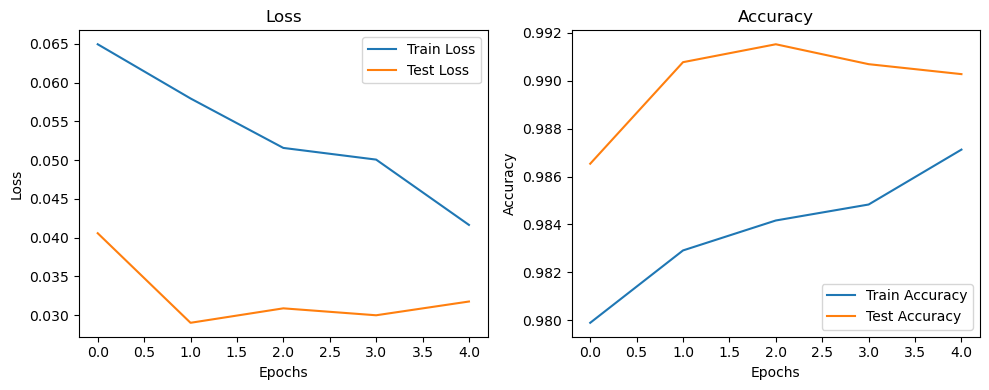

In [18]:
plot_loss_curves(model_results)

In [12]:
# STEP 5: EXPORT

# save and load as pytorch file (.pt) INFERENCE ONLY
pt_path = 'model.pt'
torch.save(model.state_dict(), pt_path)
model = CNN() # match correct model architecture
model.load_state_dict(torch.load(pt_path, weights_only=True))
model.eval()

CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.25, inplace=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, 

In [13]:
# load and export as .onnx file INFERENCE ONLY

pt_model = CNN() # match correct model architecture
pt_model.load_state_dict(torch.load(pt_path))
pt_model.eval()
ex_input = (torch.zeros(1, 1, 28, 28, dtype=torch.float32)) # match correct input dimenstions
torch.onnx.export(pt_model, 
                ex_input, 
                'C:/Users/zecer/proj/site/meta/onnx_model.onnx',
                export_params=True,
                do_constant_folding=True,
                input_names=["input"],
                output_names=["output"],
                dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
)

C:\Users\zecer\AppData\Local\Temp\ipykernel_13852\2144101711.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_model.load_state_dict(torch.load(pt_path))


In [14]:
import onnx, onnxruntime as ort
onnx.checker.check_model("C:/Users/zecer/proj/site/meta/onnx_model.onnx")  # should raise no errors
ort.InferenceSession("C:/Users/zecer/proj/site/meta/onnx_model.onnx").run(
    None, {"input": ex_input.numpy()}
)


[array([[ 0.34309313,  0.22032873,  0.1272758 , -0.02499619, -0.23599964,
          0.00161956, -0.1135145 , -0.06935146, -0.14684778, -0.34384832]],
       dtype=float32)]